## CCNSS 2018 pre-course preparation
# LIF neuron assignment

[source](https://colab.research.google.com/drive/1RtqqkgGfvVya-6xv8UVoYKI5U5oyprXs)

*Please execute the cell bellow to initialize the notebook environment*

In [0]:
import matplotlib.pyplot as plt    # import matplotlib
import matplotlib.patches as mpatches
import matplotlib.axes as ax
import seaborn as sns
sns.set()
import math                        # import basic math functions
import random                      # import basic random number generator functions
import numpy as np
import pandas as pd

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

## Objectives

In this notebook we'll implement a *Leaky Integrate-and-Fire (LIF)* neuron with stochastic pre-synaptic input current, and visualize its key statistical properties.

## Background

This neuron model is defined by a *membrane equation* and a *reset condition*:


\begin{align*}
\\
&\tau_m\,\frac{d}{dt}\,V(t) = E_{L} - V(t) + R\,I(t) &\text{if }\quad V(t) \leq V_{th}\\
\\
&V(t) = V_{r} &\text{otherwise}\\
\\
\end{align*}


where $V(t)$ is the membrane potential, $\tau_m$ is the membrane time constant, $E_{L}$ is the leak potential, $I(t)$ is the pre-synaptic input current, $V_{th}$ is the firing threshold, and $V_{r}$ is the reset voltage.

&nbsp; 

We'll extract and visualize the mean, standard deviation and histogram of the following quantities:

* Pre-synaptic input current $I(t)$
* Membrane potential $V(t)$
* Output firing frequency $\lambda(t)$

The problem will be split in several steps:

* Discrete time integration of $V(t)$ under sinusoidal pre-synaptic input, and without spikes
* Stochastic pre-synaptic input
* Visualizing ensemble statistics
* Introducing output spikes

**EXERCISE 1**

Initialize the main simulation variables.

**Suggestions**
* Modify the code below to print the main simulation parameters

In [0]:
t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere

print(t_max, dt, tau, el, vr, vth, r, i_mean)

0.15 0.001 0.02 -0.06 -0.07 -0.05 100000000.0 2.5e-10


**EXPECTED OUTPUT**

```
0.15 0.001 0.02 -0.06 -0.07 -0.05 100000000.0 2.5e-10
```

### ODE integration without spikes

The numerical integration of the membrane equation can be performed in discrete time, with a sufficiently small $\Delta t$. We start by writting the membrane equation. without taking the limit $\Delta t \to 0$ in the definition of the time derivative $d/dt\,V(t)$:


\begin{align*}
\\
\tau_m\,\frac{V\left(t+\Delta t\right)-V\left(t\right)}{\Delta t} &= E_{L} - V(t) + R\,I(t)\\
\\
\end{align*}


The value of membrane potential $V\left(t+\Delta t\right)$ can be expressed in terms of its previous value $V(t)$ by simple algebraic manipulation. For *small enough* values of $\Delta t$ this provides a good approximation of the continuous time integration.

**EXERCISE 2**

Compute the values of $V(t)$ between $t=0$ and $t=0.01$ with $V(0)=E_L$ and pre-synaptic input given by:


\begin{align*}
\\
I(t)=I_{mean}\left(1+\sin\left(\frac{2 \pi}{0.01}\,t\right)\right)
\\
\end{align*}


**Suggestions**
* Express $V\left(t+\Delta t\right)$ in terms of $V(t)$
* Initialize the membrane potential variable `v` to `el`
* Loop in the time variable `t` from `t=0` to `t=0.01` with time step `dt`
* At each time step
    * Compute the current value of `i`
    * Update the value of `v`
    * Print `v`
* Use `math.pi` and `math.sin` for evaluating $\pi$ and $\sin(\,)$, respectively

In [0]:
v_t = el
tsteps = np.arange(0.0, 0.01, dt)
for t in tsteps:
    i_t = i_mean*(1 + math.sin(((2*math.pi)/(.01))*t))
    v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
    v_t = v_tplust
    print(v_t)

-0.05875
-0.056827768434634406
-0.05454755936753374
-0.05238136075378811
-0.05077756115073311
-0.049988683093196457
-0.04997398050390223
-0.05041410212407606
-0.0508322176632412
-0.050775338345444725


**EXPECTED OUTPUT**

```
-0.05875
-0.056827768434634406
-0.05454755936753374
-0.05238136075378811
-0.05077756115073311
-0.049988683093196457
-0.04997398050390223
-0.05041410212407606
-0.0508322176632412
-0.050775338345444725
-0.050775338345444725
```

**EXERCISE 3**

Plot the values of $V(t)$ between $t=0$ and $t=t_{max}$ under the same conditions.

**Suggestions**
* Update end time of loop to `t_max`
* Replace printing command with plotting command (with keyword `'ko'`)

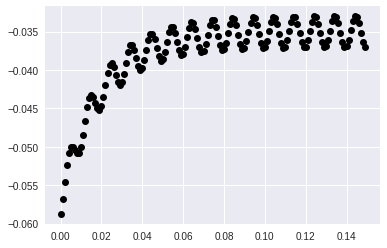

In [0]:
plt.figure()
v_t = el
tsteps = np.arange(0.0, t_max, dt)
for t in tsteps:
    i_t = i_mean*(1 + math.sin(((2*math.pi)/(.01))*t))
    v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
    v_t = v_tplust
    plt.plot(t,v_t, 'ko')

plt.show()


**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_3.png)

## Stochastic pre-synaptic input

From the standpoint of neurons, their pre-synaptic input is random. We'll improve the pre-synaptic input model by introducing random input with similar statistical properties:


\begin{align*}
\\
I(t)=I_{mean}\left(1+0.1\sqrt{\frac{t_{max}}{\Delta t}}\,\xi(t)\right)\qquad\text{with }\xi(t)\sim U(-1,1)\\
\\
\end{align*}


where $U(-1,1)$ is the uniform distribution with support $x\in[-1,1]$.


As expected, a random pre-synaptic input $I(t)$ results in a random time course $V(t)$.

**EXERCISE 4**

Plot the values of $V(t)$ between $t=0$ and $t=t_{max}$ with random input $I(t)$.

Initialize the (pseudo) random number generator to a fixed value to obtain the same random input across executions of the code (initial value `0` will reproduce the expected output). The function `random.seed()` initializes the random number generator, and `random.random()` generates samples from the uniform distribution between `0` and `1`.

**Suggestions**
* Use the function `random.seed()`to initialize the random number generator to `0`
* Use the function `random.random()` to generate the input at each timestep
* Repeat the execution several times to verify that $V(t)$ has a random time course

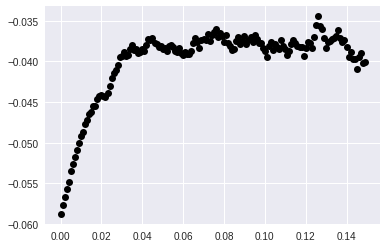

In [0]:
random.seed()

v_t = el
#data = pd.DataFrame([])
#datatest = []
tsteps = np.arange(0.0, t_max, dt)
for t in tsteps:
    i_t = i_mean*(1 + ((.1 * np.sqrt(t/dt)) * np.random.uniform(-1,1)))
    v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
    v_t = v_tplust
    plt.plot(t,v_t, 'ko')
    #datatest.append = (v_t)
    #data = data.append(pd.DataFrame(v_t)
plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_4.png)

## Ensemble statistics

Multiple runs of the previous exercise may give the impression of periodic regularity in the evolution of $V(t)$. We'll collect the sample mean over $N$ realizations of $V(t)$  with random input in order to test such hypothesis. The sample mean, sample variance and sample autocovariance at times $\left\{t_k, t_j\right\}\in[0,t_{max}]$, and for $N$ realizations of $V(t)$ are given by:

\begin{align*}
\\
\left\langle V(t_k)\right\rangle &= \frac{1}{N}\sum_{n=1}^N V(t_k)_n & & \text{sample mean}\\
\left\langle (V(t_k)-\left\langle V(t_k)\right\rangle)^2\right\rangle &= \frac{1}{N-1} \sum_{n=1}^N \left(V(t_k)_n-\left\langle V(t_k)\right\rangle\right)^2 & & \text{sample variance} \\
\left\langle \left(V(t_k)-\left\langle V(t_k)\right\rangle\right)\left(V(t_j)-\left\langle V(t_j)\right\rangle\right)\right\rangle
&= \frac{1}{N-1} \sum_{n=1}^N \left(V(t_k)_n-\left\langle V(t_k)\right\rangle\right)\left(V(t_j)_n-\left\langle V(t_j)\right\rangle\right) & & \text{sample autocovariance}\\
\\
\end{align*}

**EXERCISE 5**

Plot multiple realizations of $V(t)$.

**Suggestions**
* Create a list to store the value of $V(t)$ for each realization.
* At each timestep loop over `N=50` realizations of random input
* Plot the realizations at each time step with keyword `'ko'` and parameter `alpha=0.05`

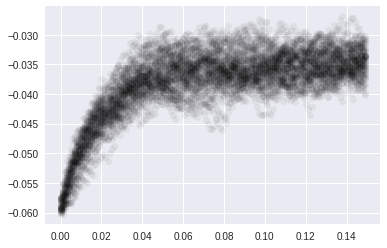

In [0]:
allv_t = []
#allsv_t = []
for sims in range(0,50):
    random.seed()
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    for t in tsteps:
        i_t = i_mean*(1 + ((.1 * np.sqrt(t_max/dt)) * np.random.uniform(-1,1)))
        v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
        v_t = v_tplust
        plt.plot(t,v_t, 'ko',alpha =0.05)
        allv_t.append([t,v_t])
    #allsv_t = allv_t.append(allv_t)
plt.show()
#plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_5.png)

**EXERCISE 6**

Plot the sample mean $\left\langle V(t)\right\rangle$ over `N=50` realizations.

**Suggestions**
* Plot the sample mean at each timestep with keyword `'C0o'` and parameter `alpha=0.8`

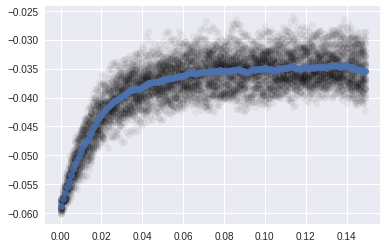

In [0]:
allv_t = []
#allsv_t = []
for sims in range(0,50):
    random.seed()
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    for t in tsteps:
        i_t = i_mean*(1 + ((.1 * np.sqrt(t_max/dt)) * np.random.uniform(-1,1)))
        v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
        v_t = v_tplust
        plt.plot(t,v_t, 'ko',alpha =0.05)
        allv_t.append([t,v_t])
    #allsv_t = allv_t.append(allv_t)

sortedvt = sorted(allv_t,key=lambda l:l[0])
vt_arr = np.array(sortedvt)
vtbytime = vt_arr[:,1].reshape(150,50)
#np.mean(vtbytime[149])
for q in range(0,150):
    mean = np.mean(vtbytime[q])
    time = tsteps[q]
    plt.plot(time,mean, 'C0o', alpha =0.8)
plt.show()


**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_6.png)

**EXERCISE 7**

Add sample standard deviation $\sigma(t_k)\equiv\sqrt{\text{Var}\left(t_k\right)}$ to the plot.

**Suggestions**
* After collecting the sample mean, iterate a second time to compute the sample variance $\sigma(t_k)$
* Plot $\left\langle V(t)\right\rangle\pm\sigma(t_k)$ with keyword `'C0o'` and parameter `alpha=0.8`.

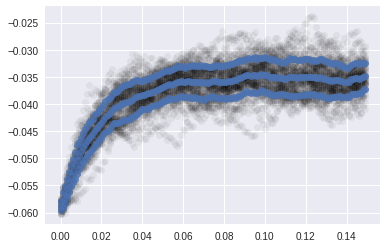

In [0]:
allv_t = []
#allsv_t = []
for sims in range(0,50):
    random.seed()
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    for t in tsteps:
        i_t = i_mean*(1 + ((.1 * np.sqrt(t_max/dt)) * np.random.uniform(-1,1)))
        v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
        v_t = v_tplust
        plt.plot(t,v_t, 'ko',alpha =0.05)
        allv_t.append([t,v_t])
    #allsv_t = allv_t.append(allv_t)

sortedvt = sorted(allv_t,key=lambda l:l[0])
vt_arr = np.array(sortedvt)
vtbytime = vt_arr[:,1].reshape(150,50)
#np.mean(vtbytime[149])
for q in range(0,150):
    mean = np.mean(vtbytime[q])
    std = np.std(vtbytime[q])
    time = tsteps[q]
    plt.plot(time,mean, 'C0o', alpha =0.8)
    plt.plot(time,mean+std, 'C0o', alpha =0.8)
    plt.plot(time,mean-std, 'C0o', alpha =0.8)
plt.show()


**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_7.png)

## Sample histogram

Another important statistic is the sample histogram at time $t_k\in[0,t_{max}]$, which for $N$ realizations $V\left(t_k\right)$ and $J$ bins is given by:
 
\begin{align*}
\\
N = \sum_{j=1}^{J} m_j\\
\\
\end{align*}

where $m_j$ is a function that counts the number of samples $V\left(t_k\right)$ that fall into bin $j$.

**EXERCISE 8**

Plot an histogram of $J=25$ bins of $V(t)$ for $t=t_{max}/10$ and $t=t_{max}$ for $N=10000$ realizations.

The function `plt.hist(data, nbins)` plots an histogram of `nbins` bins of the list 'data' and returns the lists `pdf`, `bins`, `patches`.

`pdf, bins, patches = plt.hist(data, bins)`

The parameters `histtype='stepfilled'` and `linewidth=0` may improve the plots.

**Suggestions**
* Plot the 1st histogram after running up to $t=t_{max}/10$
* Plot the 2nd histogram at $t=t_{max}$
* Add labels to identify the time of each histogram
* Plot each histogram with parameters `histtype='stepfilled'` and `linewidth=0`

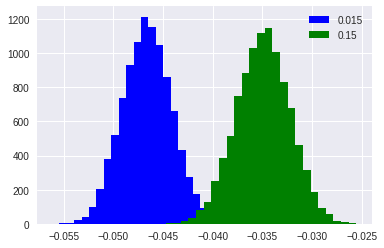

In [0]:
nrealizations = 10000 #10000
bins = 25
allv_t = []
#allsv_t = []
for sims in range(0,nrealizations):
    v_t = el
    tsteps = np.arange(0.0, t_max/10, dt)
    for t in tsteps:
        i_t = i_mean*(1 + ((.1 * np.sqrt(t_max/dt)) * np.random.uniform(-1,1)))
        v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
        v_t = v_tplust
        #plt.plot(t,v_t, 'ko',alpha =0.05)
    #allsv_t = allv_t.append(allv_t)
    allv_t.append(v_t)
plt.hist(allv_t,bins, histtype='stepfilled', linewidth = 0, color = 'b', label = '0.015')
#plt.show()
#blue_patch = mpatches.Patch(color='blue', label='0.015')
#plt.legend(handles=[blue_patch])
#plt.show()



allv_t = []
for sims in range(0,nrealizations):
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    for t in tsteps:
        i_t = i_mean*(1 + ((.1 * np.sqrt(t/dt)) * np.random.uniform(-1,1)))
        v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
        v_t = v_tplust
        #plt.plot(t,v_t, 'ko',alpha =0.05)
    allv_t.append(v_t)
    #allsv_t = allv_t.append(allv_t)
#plt.show()
plt.hist(allv_t,bins, histtype='stepfilled', linewidth = 0, color = 'g', label = '0.15')
plt.legend(loc='upper right')


#green_patch = mpatches.Patch(color='green', label='0.15')
#plt.legend(handles=[green_patch])

plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_8.png)

## Output spikes

Introduce the *reset condition*: $V(t) = V_{r} \text{if }\quad V(t)\geq V_{th}$

**EXERCISE 9**

Insert the reset condition, and collect the spike times of each realization in a dictionary variable `spikes`, with $N=500$.

**Suggestions**
* Reset $V(t)$ to $V_r$ if $V(t)\geq V_{th}$ and collect the spike time
* Plot each realization with keyword `'ko'` and parameter `alpha=0.01`
* Plot the sample mean with keyword `'C0o'` and parameter `alpha=0.8`
* Create a new figure and plot the spike times with keyword `'k.'` and parameter `alpha=0.2`
* Create a new figure and plot and the mean spiking activity

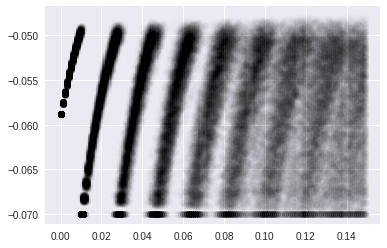

In [0]:
nreps = 500
random.seed()
spikes = {}
accumspikes = []
allv_t = []

for sims in range(0,nreps):
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    for t in tsteps:
        if v_t < vth:
            i_t = i_mean*(1 + ((.1 * np.sqrt(t/dt)) * np.random.uniform(-1,1)))
            v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
            v_t = v_tplust
            plt.plot(t,v_t, 'ko',alpha =0.01)
        else:
            accumspikes.append([t])
            v_t = vr
            plt.plot(t,v_t, 'ko',alpha =0.01)
    spikes[sims] = accumspikes
    accumspikes = []
plt.show()

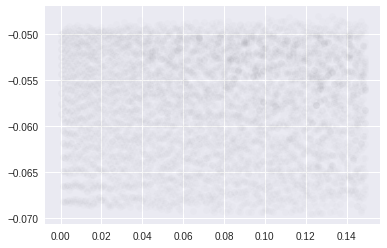

In [0]:
nreps = 2
random.seed()
spikes = {}
accumspikes = []
allv_t = []

for sims in range(0,nreps):
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    for t in tsteps:
        while v_t < vth:
            i_t = i_mean*(1 + ((.1 * np.sqrt(t/dt)) * np.random.uniform(-1,1)))
            v_tplust = ((el - v_t + r * i_t) * (dt/tau)) + v_t
            v_t = v_tplust
            plt.plot(t,v_t, 'ko',alpha =0.01)
        
        accumspikes.append([t])
        v_t = vr
        #plt.plot(t,v_t, 'ko',alpha =0.01)
    spikes[sims] = accumspikes
    accumspikes = []
plt.show()

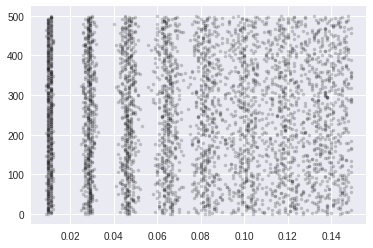

In [0]:
allspikes = []
for sims in range(0,500):
    myspikes = spikes[sims]
    simulation = [sims] * len(myspikes)
    allspikes.append(myspikes)
    plt.plot(myspikes, simulation, 'k.',alpha =0.2)

plt.show()

In [0]:
allspikescomb = [item for sublist in allspikes for item in sublist]
sortallspikescomb = sorted(allspikescomb)
arrsortallspikescomb = np.asarray(sortallspikescomb)
hist, binedges = np.histogram(arrsortallspikescomb, bins = np.linspace(0.0, 0.15, 100))


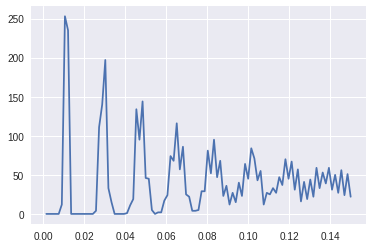

In [0]:
plt.plot(binedges[1:], hist)
plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_9a.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_9b.png)

**EXERCISE 10**

Investigate the effect of refractory period $t_{ref}$ on the evolution of output rate $\lambda(t)$.

**Suggestions**
* Add refractory period $t_{ref}=10$ ms after each spike, during which $V(t)$ is clamped to $V_r$
* Experiment increasingly higher values of refractory period $t_{ref}$

In [0]:
# insert your code here


**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_10a.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_10b.png)

**EXERCISE 11**

Below is a proposed implementation for Exercise 7 from above. Rewrite this code, but break it up into functions. Specifically, write and use function to:
* `I(n)`: returns the current, $I(t)$, at a given time $t$, a list of $n$ floats
* `mean(x)`: returns the mean of `x`, a list of floats
* `std(x)`: returns the standard deviation of `x`, a list of floats
* `ode_step(v, i)`: returns the voltage at the next time step, $V(t+\Delta t)$, given the voltage at the current time step, $V(t)$, and the current, $I(t)$, all lists of floats

In [0]:
# insert your code here

def I(n):
    '''Return I(n)'''
    I = np.zeros((n,1))
    for sims in range(0,n):
        I_hold = i_mean*(1 + ((.1 * np.sqrt(t/dt)) * np.random.uniform(-1,1)))
        I[sims] = I_hold
    return I

def mean(x):
    '''Return Mean'''
    mean = np.mean(x)
    return mean

def std(x):
    '''Return Std'''
    std = np.std(x)
    return std

def ode_step(v,i):
    '''ode_step'''
    v_tplust = np.zeros((n,1))
    holdv_tplust = ((el - v + r * i) * (dt/tau)) + v
    v_tplust = holdv_tplust
    return v_tplust


**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module0/lif_neuron/figures/lif_11.png)

**EXERCISE 12**

Rewrite the code from Exercise 11, but now use the tools from NumPy. For example:
* Use `np.array` instead of Python list for voltage, $V(t)$, and time, $t$
* Use the NumPy functions for statistical function, (e.g. `np.mean`) and mathematical (e.g. `np.sqrt`) operations
* Plot mean $\pm$ std using `plt.fill_between` with parameters `alpha='0.6'`
* Plot mean with parameter `linewidth=3`

In [0]:
# insert your code here

def I(n):
    '''Return I(n)'''
    I = np.zeros((n,1))
    for sims in range(0,n):
        I_hold = i_mean*(1 + ((.1 * np.sqrt(t/dt)) * np.random.uniform(-1,1)))
        I[sims] = I_hold
    return I

def mean(x):
    '''Return Mean'''
    mean = np.mean(x)
    return mean

def std(x):
    '''Return Std'''
    std = np.std(x)
    return std

def ode_step(v,i):
    '''ode_step'''
    v_tplust = np.zeros((n,1))
    holdv_tplust = ((el - v + r * i) * (dt/tau)) + v
    v_tplust = holdv_tplust
    return v_tplust


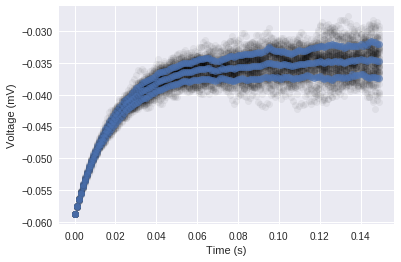

In [0]:
n =1
tsims = 50
allvs = np.zeros(tsims)
random.seed()
allsims = np.zeros((tsims,tsteps.size))
for sims in range(0,tsims):
    v_t = el
    tsteps = np.arange(0.0, t_max, dt)
    allv_t = np.zeros(tsteps.shape)
    #for t in tsteps:
    for ind,t in enumerate(tsteps):
        v_t = ode_step(v_t,I(1))
        plt.plot(t,v_t, 'ko',alpha =0.05)
        #allv_t = np.append(allv_t, v_t)
        allv_t[ind] = v_t
    allsims[sims] = allv_t   

allmean = np.mean(allsims, axis = 0)
allstd = np.std(allsims, axis = 0)
plt.plot(tsteps,allmean,'C0o', alpha =0.6)
plt.plot(tsteps,allmean+allstd, 'C0o', alpha =0.6)
plt.plot(tsteps,allmean-allstd, 'C0o', alpha =0.6)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')

plt.show()

In [0]:
print(allstd.shape)
print(allmean.shape)


(150,)
(150,)


In [0]:
(allmean + allstd).shape

(150,)

In [0]:
tsteps.shape

(150,)

In [0]:
    std = np.std(vtbytime[q])
    time = tsteps[q]
    plt.plot(time,mean, 'C0o', alpha =0.8)
    plt.plot(time,mean+std, 'C0o', alpha =0.8)
    plt.plot(time,mean-std, 'C0o', alpha =0.8)


(150, 2)

In [0]:
allv_t

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  